In [1]:
#Python version
!python --version

Python 3.8.5


In [2]:
#Install uninstalled modules, comment if it's already installed

#!pip install stable-baselines[mpi]
#!pip install ipykernel
#!pip install MetaTrader5==5.0.34
#!pip install gym
#!pip install gym-anytrading
#!pip install tensorflow==1.15.0
#!pip install quantstats

In [4]:
#Import needed modules
import gym
import gym_anytrading
from gym_anytrading.datasets import FOREX_EURUSD_1H_ASK

import numpy as np
import quantstats as qs

from stable_baselines.a2c import A2C
from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines.common.policies import MlpLstmPolicy

import matplotlib.pyplot as plt
import pandas as pd

import random, datetime, os, copy, pytz
import MetaTrader5 as mt5

In [5]:
#Trading Account Parameter
account = 647545 #Account number
password = "QpjpAGkK" #Password number
server = "FBS-Demo" #Server name
mt5_path = "C:\Program Files\FBS MetaTrader 5\terminal64.exe" #path of Metatrader5 director

mt5.initialize(
   path = mt5_path,              # path to the MetaTrader 5 terminal EXE file
   login = account,          # account number
   password = password,      # password
   server = server,          # server name as it is specified in the terminal
   #timeout = TIMEOUT,       # timeout
   portable = False          # portable mode
   )

# display data on the MetaTrader 5 package
print("MetaTrader5 package author: ",mt5.__author__)
print("MetaTrader5 package version: ",mt5.__version__,"\n")

# establish connection to the MetaTrader 5 terminal
if not mt5.initialize():
    print("initialize failed, error code =",mt5.last_error())
    mt5.shutdown()
else:
    print("MetaTrader5 Initialized!")

authorized=mt5.login(account, password, server)
if authorized:
    # display trading account data 'as is'
    print("Metatrader5 authorized!")
    account_info_dict = mt5.account_info()._asdict()
    Acc_Info = pd.DataFrame(list(account_info_dict.items()),columns=['property','value'])
    print("\n", "account_info() as dataframe:")
    print(Acc_Info)
else:
    print("Metatrader5 cant authorize, error code: {}".format(mt5.last_error()))

MetaTrader5 package author:  MetaQuotes Software Corp.
MetaTrader5 package version:  5.0.34 

MetaTrader5 Initialized!
Metatrader5 authorized!

 account_info() as dataframe:
              property             value
0                login            647545
1           trade_mode                 0
2             leverage              1000
3         limit_orders               100
4       margin_so_mode                 0
5        trade_allowed              True
6         trade_expert              True
7          margin_mode                 2
8      currency_digits                 2
9           fifo_close             False
10             balance            100000
11              credit                 0
12              profit                 0
13              equity            100000
14              margin                 0
15         margin_free            100000
16        margin_level                 0
17      margin_so_call                40
18        margin_so_so                20
19    

In [6]:
#Extract Account info from dataframe
leverage = Acc_Info.loc[2, "value"]
equity = Acc_Info.loc[13, "value"]
margin_free = Acc_Info.loc[15, "value"]

print(leverage)
print(equity)
print(margin_free)

1000
100000.0
100000.0


In [7]:
Symbol = "EURJPY"
Timeframe = mt5.TIMEFRAME_M5
symbol_info = mt5.symbol_info(Symbol)
if symbol_info!=None:
    # display the terminal data 'as is'    
    print(symbol_info)
    print("EURJPY: spread =",symbol_info.spread,"  digits =",symbol_info.digits, "\n")
    # display symbol properties as a list
    
    print(symbol_info[3])

SymbolInfo(custom=False, chart_mode=0, select=False, visible=False, session_deals=0, session_buy_orders=0, session_sell_orders=0, volume=0, volumehigh=0, volumelow=0, time=0, digits=3, spread=0, spread_float=True, ticks_bookdepth=0, trade_calc_mode=0, trade_mode=4, start_time=0, expiration_time=0, trade_stops_level=1, trade_freeze_level=0, trade_exemode=2, swap_mode=1, swap_rollover3days=3, margin_hedged_use_leg=False, expiration_mode=15, filling_mode=3, order_mode=127, order_gtc_mode=0, option_mode=0, option_right=0, bid=0.0, bidhigh=0.0, bidlow=0.0, ask=0.0, askhigh=0.0, asklow=0.0, last=0.0, lasthigh=0.0, lastlow=0.0, volume_real=0.0, volumehigh_real=0.0, volumelow_real=0.0, option_strike=0.0, point=0.001, trade_tick_value=0.9135757354284672, trade_tick_value_profit=0.9135757354284672, trade_tick_value_loss=0.913709294250941, trade_tick_size=0.001, trade_contract_size=100000.0, trade_accrued_interest=0.0, trade_face_value=0.0, trade_liquidity_rate=0.0, volume_min=0.01, volume_max=10

In [44]:
# set time zone to UTC
timezone = pytz.timezone("Etc/UTC")
# create 'datetime' object in UTC time zone to avoid the implementation of a local time zone offset
utc_from = datetime.datetime(2020, 1, 10, tzinfo=timezone)

# getbars from the current day
rates = mt5.copy_rates_from_pos(Symbol, Timeframe, 0, 120)
 
# create DataFrame out of the obtained data
rates_frame = pd.DataFrame(rates, dtype=np.dtype("float"))
# convert time in seconds into the datetime format
rates_frame['time']=pd.to_datetime(rates_frame['time'], unit='s')
                           
# display data
print("\nDisplay dataframe with data")
print(rates_frame)

rates_frame.to_csv('./Datasets/{}.csv'.format(Symbol), index=False)
pd.read_csv('./Datasets/{}.csv'.format(Symbol))


Display dataframe with data
                   time     open     high      low    close  tick_volume  \
0   2021-06-08 18:40:00  133.310  133.319  133.301  133.306        106.0   
1   2021-06-08 18:45:00  133.306  133.316  133.297  133.301        113.0   
2   2021-06-08 18:50:00  133.301  133.327  133.300  133.319        123.0   
3   2021-06-08 18:55:00  133.320  133.334  133.319  133.324        119.0   
4   2021-06-08 19:00:00  133.327  133.335  133.320  133.327        121.0   
..                  ...      ...      ...      ...      ...          ...   
115 2021-06-09 04:20:00  133.213  133.232  133.204  133.232         69.0   
116 2021-06-09 04:25:00  133.234  133.234  133.220  133.227         39.0   
117 2021-06-09 04:30:00  133.226  133.230  133.210  133.230        106.0   
118 2021-06-09 04:35:00  133.230  133.239  133.213  133.223        115.0   
119 2021-06-09 04:40:00  133.222  133.223  133.222  133.223          4.0   

     spread  real_volume  
0      20.0          0.0  
1   

,time,open,high,low,close,tick_volume,spread,real_volume
0,2021-06-08 18:40:00,133.310,133.319,133.301,133.306,106.0,20.0,0.0
1,2021-06-08 18:45:00,133.306,133.316,133.297,133.301,113.0,19.0,0.0
2,2021-06-08 18:50:00,133.301,133.327,133.300,133.319,123.0,19.0,0.0
3,2021-06-08 18:55:00,133.320,133.334,133.319,133.324,119.0,19.0,0.0
4,2021-06-08 19:00:00,133.327,133.335,133.320,133.327,121.0,21.0,0.0
...,...,...,...,...,...,...,...,...
115,2021-06-09 04:20:00,133.213,133.232,133.204,133.232,69.0,20.0,0.0
116,2021-06-09 04:25:00,133.234,133.234,133.220,133.227,39.0,19.0,0.0
117,2021-06-09 04:30:00,133.226,133.230,133.210,133.230,106.0,20.0,0.0
118,2021-06-09 04:35:00,133.230,133.239,133.213,133.223,115.0,20.0,0.0


In [63]:
df = pd.read_csv('./Datasets/{}.csv'.format(Symbol))
df['time'] = pd.to_datetime(df['time'])
df = df.rename(columns={
    "time":"Date",
    "open":"Open",
    "high":"High",
    "low":"Low",
    "close":"Close",
    "tick_volume":"Tick_volume",
    "spread":"Spread",
    "real_volume":"Real_volume"
})
df.head

<bound method NDFrame.head of                    Date     Open     High      Low    Close  Tick_volume  \
0   2021-06-08 18:40:00  133.310  133.319  133.301  133.306        106.0   
1   2021-06-08 18:45:00  133.306  133.316  133.297  133.301        113.0   
2   2021-06-08 18:50:00  133.301  133.327  133.300  133.319        123.0   
3   2021-06-08 18:55:00  133.320  133.334  133.319  133.324        119.0   
4   2021-06-08 19:00:00  133.327  133.335  133.320  133.327        121.0   
..                  ...      ...      ...      ...      ...          ...   
115 2021-06-09 04:20:00  133.213  133.232  133.204  133.232         69.0   
116 2021-06-09 04:25:00  133.234  133.234  133.220  133.227         39.0   
117 2021-06-09 04:30:00  133.226  133.230  133.210  133.230        106.0   
118 2021-06-09 04:35:00  133.230  133.239  133.213  133.223        115.0   
119 2021-06-09 04:40:00  133.222  133.223  133.222  133.223          4.0   

     Spread  Real_volume  
0      20.0          0.0  
1  


env information:
> shape: (10, 2)
> df.shape: (120, 8)
> prices.shape: (120,)
> signal_features.shape: (120, 2)
> max_possible_profit: 1.0034368196551524


> possible action: Discrete(2)
> observation space: Box(-inf, inf, (10, 2), float32)


> signal features:  [[ 1.33306e+02  0.00000e+00]
 [ 1.33301e+02 -5.00000e-03]
 [ 1.33319e+02  1.80000e-02]
 [ 1.33324e+02  5.00000e-03]
 [ 1.33327e+02  3.00000e-03]
 [ 1.33346e+02  1.90000e-02]
 [ 1.33358e+02  1.20000e-02]
 [ 1.33348e+02 -1.00000e-02]
 [ 1.33356e+02  8.00000e-03]
 [ 1.33343e+02 -1.30000e-02]
 [ 1.33343e+02  0.00000e+00]
 [ 1.33352e+02  9.00000e-03]
 [ 1.33362e+02  1.00000e-02]
 [ 1.33343e+02 -1.90000e-02]
 [ 1.33352e+02  9.00000e-03]
 [ 1.33342e+02 -1.00000e-02]
 [ 1.33339e+02 -3.00000e-03]
 [ 1.33327e+02 -1.20000e-02]
 [ 1.33334e+02  7.00000e-03]
 [ 1.33343e+02  9.00000e-03]
 [ 1.33327e+02 -1.60000e-02]
 [ 1.33320e+02 -7.00000e-03]
 [ 1.33336e+02  1.60000e-02]
 [ 1.33336e+02  0.00000e+00]
 [ 1.33328e+02 -8.00000e-03]
 [ 1.33323e

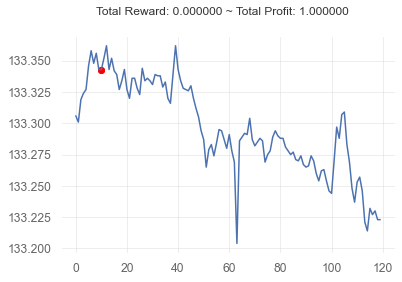

In [65]:
window_size = 10
env = gym.make('forex-v0',
               df = df,
               window_size = window_size,
               frame_bound = (window_size, len(df)), #Max 6225 Rows of data
               unit_side = 'right')

seed = 42
env.seed(seed)
eps = np.finfo(np.float32).eps.item()

print()
print("env information:")
print("> shape:", env.shape)
print("> df.shape:", env.df.shape)
print("> prices.shape:", env.prices.shape)
print("> signal_features.shape:", env.signal_features.shape)
print("> max_possible_profit:", env.max_possible_profit())
print("\n")
print("> possible action:", env.action_space)
print("> observation space:", env.observation_space)
print("\n")
print("> signal features: ", env.signal_features)

env.reset() # Uncomment if you need it.
env.render()


In [66]:
print(env.df)
print("\n")
env.df.info()

                   Date     Open     High      Low    Close  Tick_volume  \
0   2021-06-08 18:40:00  133.310  133.319  133.301  133.306        106.0   
1   2021-06-08 18:45:00  133.306  133.316  133.297  133.301        113.0   
2   2021-06-08 18:50:00  133.301  133.327  133.300  133.319        123.0   
3   2021-06-08 18:55:00  133.320  133.334  133.319  133.324        119.0   
4   2021-06-08 19:00:00  133.327  133.335  133.320  133.327        121.0   
..                  ...      ...      ...      ...      ...          ...   
115 2021-06-09 04:20:00  133.213  133.232  133.204  133.232         69.0   
116 2021-06-09 04:25:00  133.234  133.234  133.220  133.227         39.0   
117 2021-06-09 04:30:00  133.226  133.230  133.210  133.230        106.0   
118 2021-06-09 04:35:00  133.230  133.239  133.213  133.223        115.0   
119 2021-06-09 04:40:00  133.222  133.223  133.222  133.223          4.0   

     Spread  Real_volume  
0      20.0          0.0  
1      19.0          0.0  
2     

In [67]:
'''
def my_process_data(df, window_size, frame_bound):
    start = frame_bound[0] - window_size
    end = frame_bound[1]
    prices = df.loc[:, 'Low'].to_numpy()[start:end]
    signal_features = df.loc[:, ['Open', 'High', 'Low', 'Close', 'Volume']].to_numpy()[start:end]
    return prices, signal_features

prices, signal_features = my_process_data(
            df = FOREX_EURUSD_1H_ASK,
            window_size = 10,
            frame_bound = (10, 800), #Max 6225 Rows of data
)

print(prices)
print("\n")
print(signal_features)
'''

'\ndef my_process_data(df, window_size, frame_bound):\n    start = frame_bound[0] - window_size\n    end = frame_bound[1]\n    prices = df.loc[:, \'Low\'].to_numpy()[start:end]\n    signal_features = df.loc[:, [\'Open\', \'High\', \'Low\', \'Close\', \'Volume\']].to_numpy()[start:end]\n    return prices, signal_features\n\nprices, signal_features = my_process_data(\n            df = FOREX_EURUSD_1H_ASK,\n            window_size = 10,\n            frame_bound = (10, 800), #Max 6225 Rows of data\n)\n\nprint(prices)\nprint("\n")\nprint(signal_features)\n'

info: {'total_reward': -140.00000000066848, 'total_profit': 0.9994369096553865, 'position': 1}


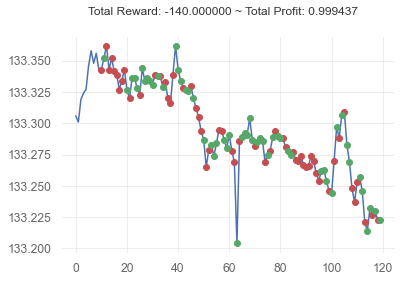

In [68]:
# Based on random actions

observation = env.reset()
while True:
    action = env.action_space.sample()
    observation, reward, done, info = env.step(action)
    # env.render()
    if done:
        print("info:", info)
        break

plt.cla()
env.render_all()
plt.show()